# Курсовой проект по предмету "Библиотеки Python для Data Science"

## План занятия:

0. Подключение библиотек
1. Загрузка данных
2. EDA (исследователький анализ данных)
3. Обработка выбросов
4. Обработка пропусков
5. Построение новых признаков
6. Создание классов
7. Отбор признаков
8. Разбиение на train и test
9. Построение модели
10. Прогнозирование на тестовом датасете

Комментарий ко всему проекту: основные типовые куски я копировал из разных уроков, кода с вебинара или домашнего задания, в моем или Вашем исполнении соответсвенно, принципиально новая работа в проекте проведена с подбором признаков для улучшения модели.

## 0. Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import pickle   # сохранение модели
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

## 1. Загрузка данных

In [2]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
SAMPLE_SUBMISSION = './sample_submission.csv'

train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')

train_df.sample()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
5190,6048,21,2.0,43.231874,23.15949,6.0,2,14.0,1973,0.034331,B,B,25,5487,3,NaN,0,4,B,168729.95844


In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

train_df.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

## 2. EDA (исследователький анализ данных)

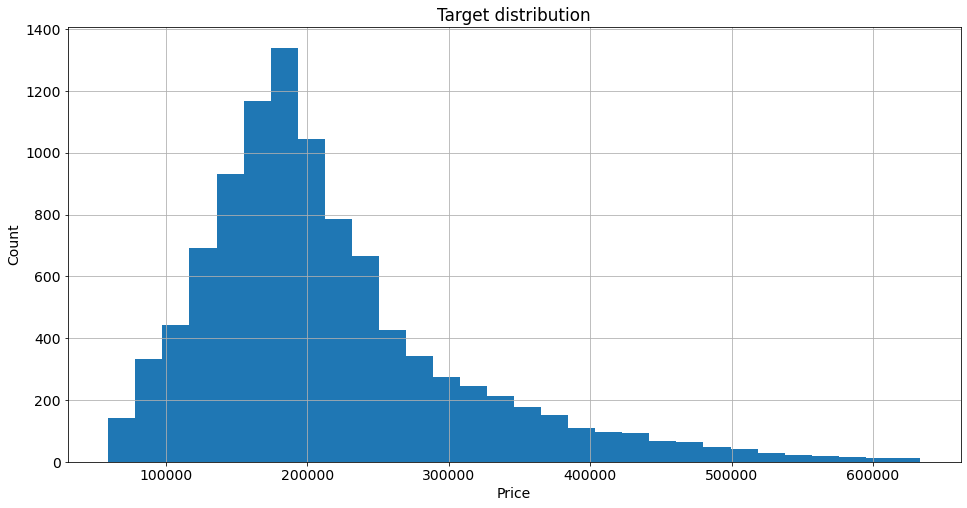

In [5]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [6]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [7]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [8]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## 3. Обработка выбросов


* **Комнаты и площади**

In [9]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [10]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

In [11]:
train_df['Square'].value_counts()

26.553188     1
46.363496     1
100.751999    1
70.726600     1
40.523022     1
             ..
76.481158     1
86.915187     1
82.482521     1
43.112986     1
97.664912     1
Name: Square, Length: 10000, dtype: int64

In [12]:
train_df['Square'].quantile(.975), train_df['Square'].quantile(.025)

(100.90624548226137, 32.10518291149681)

In [13]:
condition_square = (train_df['Square'].isna()) | (train_df['Square'] > train_df['Square'].quantile(.975))
        
train_df.loc[condition_square, 'Square'] = train_df['Square'].median()

train_df.loc[train_df['Square'] < 20, 'Square'] = 20

In [14]:
train_df['Square'].value_counts()

52.513310    250
20.000000     21
52.653623      1
64.227992      1
52.940423      1
            ... 
53.020530      1
64.580206      1
58.839152      1
61.693370      1
75.775988      1
Name: Square, Length: 9731, dtype: int64

In [15]:
condition_kitchensquare = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition_kitchensquare, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [16]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

* **Этажность**

In [17]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [18]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [19]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [20]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = 1

In [21]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] = train_df['HouseFloor']

In [22]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

* **Год постройки**

In [23]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [24]:
train_df['HouseYear'][9163] = 2011
train_df['HouseYear'][8828] = 1968
train_df['HouseYear'].sort_values(ascending=False)

8664    2020
7207    2020
7721    2020
5641    2020
1004    2020
        ... 
7610    1916
6250    1914
2066    1912
2795    1912
6794    1910
Name: HouseYear, Length: 10000, dtype: int64

## 3. Обработка пропусков

* **Жилая площадь**

С этим признаком я долго возился. Там были значения, которые больше разницы общей и кухни, были, которые сильно меньше этой разницы. В итоге, все эти отклонения и пропуски заполнил разницей площадей общей и кухни.

In [25]:
lifesquare = train_df['Square'] - train_df['KitchenSquare'] - 3
LifeSquare_outliers = train_df.loc[train_df['LifeSquare'] > lifesquare].index
LifeSquare_outliers.value_counts()

7748    1
4777    1
8863    1
672     1
675     1
       ..
3409    1
5459    1
6581    1
5461    1
4701    1
Length: 1356, dtype: int64

In [26]:
train_df['LifeSquare_outlier'] = 0
train_df.loc[train_df['LifeSquare'].isna() | train_df['LifeSquare'] > lifesquare, 'LifeSquare_outlier'] = 1
train_df.loc[train_df['LifeSquare'] < train_df['KitchenSquare']*3, 'LifeSquare_outlier'] = 1

condition = (train_df['LifeSquare'].isna()) | (train_df['LifeSquare'] > lifesquare)
train_df.loc[condition, 'LifeSquare'] = lifesquare

train_df.loc[train_df['LifeSquare'] > lifesquare, 'LifeSquare'] = lifesquare

In [27]:
LifeSquare_outliers = train_df.loc[train_df['LifeSquare'] > lifesquare].index
LifeSquare_outliers.value_counts()

Series([], dtype: int64)

In [28]:
train_df['LifeSquare'].sort_values(ascending=False)

9068    94.751999
4544    94.648276
9827    94.418743
8627    94.294193
2624    93.348269
          ...    
6882     1.049867
9869     0.873147
119      0.795539
1829     0.641822
3113     0.370619
Name: LifeSquare, Length: 10000, dtype: float64

In [29]:
train_df.loc[train_df['LifeSquare'] < train_df['KitchenSquare']*3, 'LifeSquare'] = lifesquare

In [30]:
train_df['LifeSquare'].sort_values(ascending=False)

9068    94.751999
4544    94.648276
9827    94.418743
8627    94.294193
2624    93.348269
          ...    
8065    10.845368
299     10.651455
9286    10.000000
3686     9.000000
9349     9.000000
Name: LifeSquare, Length: 10000, dtype: float64

* **Здравоохранение**

In [31]:
train_df['Healthcare_1'].value_counts()

540.0     511
30.0      348
1046.0    245
750.0     163
229.0     148
         ... 
370.0      14
32.0       12
1815.0     10
35.0        2
0.0         1
Name: Healthcare_1, Length: 79, dtype: int64

In [32]:
train_df['Healthcare_1_outlier'] = 0
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1_outlier'] = 1
median = train_df['Healthcare_1'].median()
train_df['Healthcare_1'] = train_df['Healthcare_1'].fillna(median)

In [33]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_outlier,Healthcare_1_outlier
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.887600,54.520107,39.906966,6.238200,7.727300,12.63630,1984.866300,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.001200,0.182500,0.164400,0.479800
std,0.811438,15.760001,14.735494,2.794717,5.267344,6.72767,18.412271,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.034622,0.386275,0.370657,0.499617
min,1.000000,20.000000,9.000000,3.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.774881,29.613946,3.000000,4.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,0.000000,0.000000,0.000000,0.000000
50%,2.000000,52.513040,35.934779,6.000000,7.000000,13.00000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,0.000000,0.000000,0.000000
75%,2.000000,64.591720,47.649362,8.000000,11.000000,17.00000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,0.000000,0.000000,0.000000,1.000000
max,5.000000,100.904263,94.751999,13.000000,42.000000,117.00000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000


In [34]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.square_quantile = None
        self.kitchen_square_quantile = None
        self.lifesquare = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.square_quantile = X['Square'].quantile(.975)
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
            
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.kitchen_square_quantile)
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # Square
        condition = (X['Square'].isna()) | (X['Square'] > self.square_quantile)
        X.loc[condition, 'Square'] = self.medians['Square']
        X.loc[X['Square'] < 20, 'Square'] = 20
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X['HouseFloor']
        
        # HouseYear
        current_year = datetime.now().year
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # LifeSquare
        
        lifesquare = X['Square'] - X['KitchenSquare'] - 3
        X['LifeSquare_outlier'] = 0
        X.loc[X['LifeSquare'].isna() | X['LifeSquare'] > lifesquare, 'LifeSquare_outlier'] = 1
        X.loc[X['LifeSquare'] < X['KitchenSquare']*3, 'LifeSquare_outlier'] = 1
        condition = (X['LifeSquare'].isna()) | (X['LifeSquare'] > lifesquare)
        X.loc[condition, 'LifeSquare'] = lifesquare
        X.loc[X['LifeSquare'] < X['KitchenSquare']*3, 'LifeSquare'] = lifesquare
        
        # Healthcare_1
        X['Healthcare_1_outlier'] = 0
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1_outlier'] = 1
        X['Healthcare_1'] = X['Healthcare_1'].fillna(self.medians['Healthcare_1'])
        
        X.fillna(self.medians, inplace=True)
        
        return X

## 5. Построение новых признаков

* **Преобразование строковых**

In [35]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

* **Район по размеру**

In [36]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [37]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_outlier,Healthcare_1_outlier,DistrictSize
0,11809,27,3.0,52.513310,39.513310,10.0,4.0,10.0,2014,0.075424,...,900.0,0,0,1,305018.871089,0,0,0,1,851
1,3013,22,1.0,39.832524,28.832524,8.0,7.0,8.0,1966,0.118537,...,1183.0,1,0,1,177734.553407,0,0,1,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,240.0,3,1,1,282078.720850,0,0,0,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,900.0,0,1,1,168106.007630,0,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,900.0,0,6,1,343995.102962,0,0,0,1,89


* **Цена по району**

Тут посчитал лишним количество комнат и сделал срецднюю цену квадратного метра по району, по году и по году в районе. Понимаю, что признаки опасные - возможно переобучение, но захотел поэкспериментировать.

In [38]:
train_df['Price_by_Square'] = train_df['Price'] / train_df['Square']
train_df['Price_by_Square'].value_counts()

3245.902616    1
3470.884162    1
6136.249310    1
4342.460222    1
4773.949192    1
              ..
1567.206801    1
5105.075201    1
4727.241986    1
3714.822888    1
2733.333847    1
Name: Price_by_Square, Length: 10000, dtype: int64

In [39]:
price_by_district = train_df.groupby(['DistrictId'], as_index=False).agg({'Price_by_Square':'median'})\
                            .rename(columns={'Price_by_Square':'PriceByDistrict'})

price_by_district.head()

,DistrictId,PriceByDistrict
0,0,4006.153001
1,1,3252.677215
2,10,4458.893222
3,100,4933.389994
4,101,4188.414745


In [40]:
train_df = train_df.merge(price_by_district, on=['DistrictId'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_outlier,Healthcare_1_outlier,DistrictSize,Price_by_Square,PriceByDistrict
0,11809,27,3.0,52.513310,39.513310,10.0,4.0,10.0,2014,0.075424,...,0,1,305018.871089,0,0,0,1,851,5808.410697,2773.258166
1,3013,22,1.0,39.832524,28.832524,8.0,7.0,8.0,1966,0.118537,...,0,1,177734.553407,0,0,1,0,78,4462.045990,3553.678687
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,1,1,282078.720850,0,0,0,0,652,3600.596698,3252.677215
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,1,1,168106.007630,0,0,0,1,652,4160.019670,3252.677215
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,6,1,343995.102962,0,0,0,1,89,5351.088794,4219.992382


* **Цена по году**

In [41]:
def year_to_cat(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [42]:
train_df = year_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_outlier,Healthcare_1_outlier,DistrictSize,Price_by_Square,PriceByDistrict,year_cat
0,11809,27,3.0,52.513310,39.513310,10.0,4.0,10.0,2014,0.075424,...,1,305018.871089,0,0,0,1,851,5808.410697,2773.258166,5
1,3013,22,1.0,39.832524,28.832524,8.0,7.0,8.0,1966,0.118537,...,1,177734.553407,0,0,1,0,78,4462.045990,3553.678687,2
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,1,282078.720850,0,0,0,0,652,3600.596698,3252.677215,3
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,1,168106.007630,0,0,0,1,652,4160.019670,3252.677215,2
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,1,343995.102962,0,0,0,1,89,5351.088794,4219.992382,2


In [43]:
price_by_year = train_df.groupby(['year_cat'], as_index=False).agg({'Price_by_Square':'median'}).\
                                            rename(columns={'Price_by_Square':'PriceByYear'})
price_by_year.head()

,year_cat,PriceByYear
0,0,5425.004813
1,1,6302.113166
2,2,3856.675207
3,3,4387.793125
4,4,4502.593870


In [44]:
train_df = train_df.merge(price_by_year, on=['year_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_outlier,Healthcare_1_outlier,DistrictSize,Price_by_Square,PriceByDistrict,year_cat,PriceByYear
0,11809,27,3.0,52.513310,39.513310,10.0,4.0,10.0,2014,0.075424,...,305018.871089,0,0,0,1,851,5808.410697,2773.258166,5,3024.209620
1,3013,22,1.0,39.832524,28.832524,8.0,7.0,8.0,1966,0.118537,...,177734.553407,0,0,1,0,78,4462.045990,3553.678687,2,3856.675207
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,282078.720850,0,0,0,0,652,3600.596698,3252.677215,3,4387.793125
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,168106.007630,0,0,0,1,652,4160.019670,3252.677215,2,3856.675207
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,343995.102962,0,0,0,1,89,5351.088794,4219.992382,2,3856.675207


* **Цена по году в каждом районе**

In [45]:
price_by_year_district = train_df.groupby(['DistrictId', 'year_cat'], as_index=False).agg({'Price_by_Square':'median'})\
                            .rename(columns={'Price_by_Square':'PriceByYearDistrict'})

price_by_year_district.head()

,DistrictId,year_cat,PriceByYearDistrict
0,0,2,4285.608568
1,0,3,4100.076320
2,0,4,5012.652277
3,0,5,2725.782682
4,1,2,3251.647396


In [46]:
train_df = train_df.merge(price_by_year_district, on=['DistrictId', 'year_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,LifeSquare_outlier,Healthcare_1_outlier,DistrictSize,Price_by_Square,PriceByDistrict,year_cat,PriceByYear,PriceByYearDistrict
0,11809,27,3.0,52.513310,39.513310,10.0,4.0,10.0,2014,0.075424,...,0,0,0,1,851,5808.410697,2773.258166,5,3024.209620,2769.135334
1,3013,22,1.0,39.832524,28.832524,8.0,7.0,8.0,1966,0.118537,...,0,0,1,0,78,4462.045990,3553.678687,2,3856.675207,3482.509526
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,0,0,0,652,3600.596698,3252.677215,3,4387.793125,3699.034766
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,0,0,0,1,652,4160.019670,3252.677215,2,3856.675207,3251.647396
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,0,0,1,89,5351.088794,4219.992382,2,3856.675207,4219.343480


In [47]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.price_by_district = None
        self.price_by_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.price_by_district = None

    def fit(self, X, y=None):
                
        X = X.copy()
                
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            df['Price_by_Square'] = df['Price'] / df['Square']
            self.price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Price_by_Square':'median'})\
                                            .rename(columns={'Price_by_Square':'PriceByDistrict'})
            self.price_by_district_median = self.price_by_district['PriceByDistrict'].median()
            
        ## year
        self.house_year_max = df['HouseYear'].max()
        
        if y is not None:
            df['Price'] = y.values
            df['Price_by_Square'] = df['Price'] / df['Square']
            df = self.year_to_cat(df)
            self.price_by_year = df.groupby(['year_cat'], as_index=False).agg({'Price_by_Square':'median'}).\
                                            rename(columns={'Price_by_Square':'PriceByYear'})
            self.price_by_year_median = self.price_by_year['PriceByYear'].median()
        
        ## PriceByYearDistrict
        if y is not None:
            df['Price'] = y.values
            df['Price_by_Square'] = df['Price'] / df['Square']
            self.price_by_year_district = df.groupby(['DistrictId', 'year_cat'], as_index=False).agg({'Price_by_Square':'median'})\
                            .rename(columns={'Price_by_Square':'PriceByYearDistrict'})    
            self.price_by_year_district_median = self.price_by_year_district['PriceByYearDistrict'].median()
      
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        # More categorical features
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.price_by_district is not None:
            X = X.merge(self.price_by_district, on=['DistrictId'], how='left')
            X.fillna(self.price_by_district_median, inplace=True)
            
        if self.price_by_year is not None:
            X = X.merge(self.price_by_year, on=['year_cat'], how='left')
            X.fillna(self.price_by_year_median, inplace=True)
        
        if self.price_by_year_district is not None:    
            X = X.merge(self.price_by_year_district, on=['DistrictId', 'year_cat'], how='left')
            X.fillna(self.price_by_year_district_median, inplace=True)
        
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

## 6. Разбиение на Трейн и Валид

In [48]:
target_name = 'Price'

In [49]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [51]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 24), (3000, 24), (5000, 24))

In [52]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 29), (3000, 29), (5000, 29))

In [53]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

## 7. Отбор признаков

In [54]:
X_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'LifeSquare_outlier',
 'Healthcare_1_outlier',
 'DistrictSize',
 'year_cat',
 'PriceByDistrict',
 'PriceByYear',
 'PriceByYearDistrict']

In [55]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1']

new_feature_names = ['DistrictSize', 'PriceByYear']

X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [56]:
X_train = reduce_mem_usage(X_train)
X_valid = reduce_mem_usage(X_valid)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.75 MB
Memory usage after optimization is: 0.33 MB
Decreased by 56.2%
Memory usage of dataframe is 0.32 MB
Memory usage after optimization is: 0.15 MB
Decreased by 54.5%
Memory usage of dataframe is 0.53 MB
Memory usage after optimization is: 0.24 MB
Decreased by 54.5%


## 8. Стандартизация

In [57]:
feature_names_for_stand = X_train.select_dtypes(include=['float32', 'int16']).columns.tolist()
scaler = StandardScaler()

stand_features_train = scaler.fit_transform(X_train[feature_names_for_stand])
stand_features_valid = scaler.transform(X_valid[feature_names_for_stand])
stand_features_test = scaler.transform(test_df[feature_names_for_stand])

In [58]:
X_train[feature_names_for_stand] = stand_features_train
X_valid[feature_names_for_stand] = stand_features_valid
test_df[feature_names_for_stand] = stand_features_test

In [59]:
test_df.head()

,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,DistrictSize,PriceByYear
0,-1.092357,-1.123581,-1.413878,-0.502562,-0.526591,-0.799045,-0.685251,24,-0.239940,-0.335931,0.017327,-0.518427,-0.025869
1,-1.092357,-0.760394,-0.704230,-0.118990,0.665706,1.759928,-0.383540,2,-1.172976,-0.293442,-0.165358,0.007018,-1.829814
2,0.142144,0.331158,0.521976,2.182446,0.963780,-0.417922,0.782299,9,-0.858646,-0.335931,-0.165358,2.219142,-0.025869
3,1.376645,-0.300346,-0.403992,-1.077921,-1.569850,-1.071277,-0.869862,2,-1.211303,-0.335931,-0.165358,1.147234,-0.025869
4,-1.092357,-0.030765,0.547455,0.072797,0.665706,-0.417922,1.603471,35,0.590560,-0.165974,-0.044463,-0.486900,-0.025869


## 9. Обучение

R2:	0.874
RMSE:	32514.816
MSE:	1057213246.323


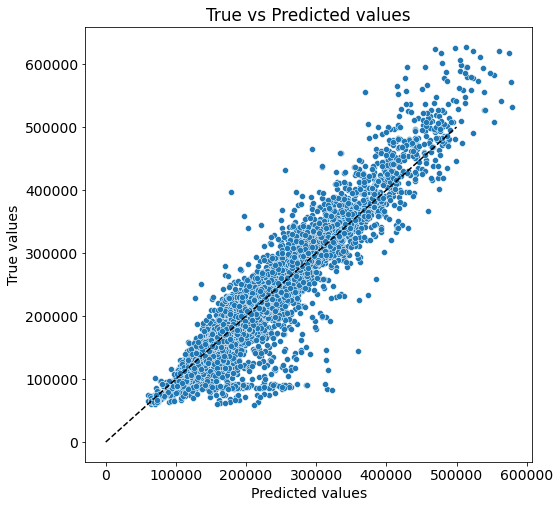

In [60]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=200)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.738
RMSE:	49140.542
MSE:	2414792904.302


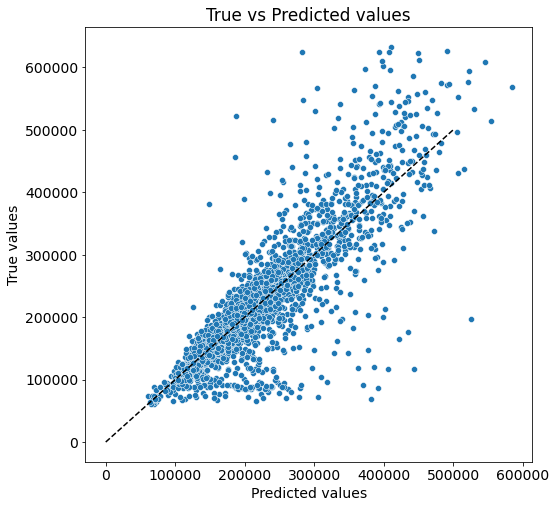

In [61]:
y_valid_preds = gb_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

In [62]:
gb_model.feature_importances_

array([0.03477005, 0.40909575, 0.02550285, 0.01042861, 0.02632584,
       0.02660986, 0.03586589, 0.02228014, 0.0356365 , 0.05916761,
       0.01530289, 0.28228074, 0.01673327])

In [63]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [64]:
feature_importances.head(5)

,feature_name,importance
1,Square,0.409096
11,DistrictSize,0.282281
9,Social_3,0.059168
6,Ecology_1,0.035866
8,Social_2,0.035637


In [65]:
feature_importances.tail(5)

,feature_name,importance
2,LifeSquare,0.025503
7,Social_1,0.022280
12,PriceByYear,0.016733
10,Healthcare_1,0.015303
3,Floor,0.010429


## 10. Кроссвалидация

In [66]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.71634057, 0.73800459, 0.69851844])

In [67]:
cv_score.mean()

0.7176211996729176

Сколько не пробовал StackingRegressor, он в любых комбинациях был хуже чем просто GradientBoostingRegressor.

## 8. Прогнозирование на тестовом датасете 

In [68]:
test_df.shape

(5000, 13)

In [69]:
test_df

,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,DistrictSize,PriceByYear
0,-1.092357,-1.123581,-1.413878,-0.502562,-0.526591,-0.799045,-0.685251,24,-0.239940,-0.335931,0.017327,-0.518427,-0.025869
1,-1.092357,-0.760394,-0.704230,-0.118990,0.665706,1.759928,-0.383540,2,-1.172976,-0.293442,-0.165358,0.007018,-1.829814
2,0.142144,0.331158,0.521976,2.182446,0.963780,-0.417922,0.782299,9,-0.858646,-0.335931,-0.165358,2.219142,-0.025869
3,1.376645,-0.300346,-0.403992,-1.077921,-1.569850,-1.071277,-0.869862,2,-1.211303,-0.335931,-0.165358,1.147234,-0.025869
4,-1.092357,-0.030765,0.547455,0.072797,0.665706,-0.417922,1.603471,35,0.590560,-0.165974,-0.044463,-0.486900,-0.025869
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.142144,-0.716422,-0.646499,-0.502562,-1.122739,-1.234615,-0.404448,31,0.193353,-0.165974,-0.165358,-0.576226,-0.025869
4996,1.376645,2.533232,2.789801,2.566019,2.156077,1.814375,-0.479026,15,-0.635902,-0.250953,-0.675801,-0.770640,-1.829814
4997,-1.092357,-1.328831,-1.420082,-1.077921,-1.122739,-1.016830,-0.663727,28,0.296388,-0.293442,-0.010881,-0.528936,-0.025869
4998,-1.092357,-1.008602,-0.899303,0.072797,0.218595,-0.799045,-0.242191,33,0.655516,-0.123485,-0.165358,-0.712841,-0.025869


In [70]:
submit = pd.read_csv(SAMPLE_SUBMISSION)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [71]:
predictions = gb_model.predict(test_df)
predictions

array([165310.16832767, 123379.95417166, 138602.49139433, ...,
       139898.31966652, 193911.85999272, 253517.89952145])

In [72]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,165310.168328
1,5925,123379.954172
2,960,138602.491394
3,3848,136163.385163
4,746,173514.477627


In [73]:
submit.to_csv('rf_submit.csv', index=False)